In [1]:
import sys, os
# if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

#     !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/td3_and_sac/logger.py

#     !pip -q install gymnasium[mujoco]==1.0.0
#     !pip -q install tensorboardX

#     !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


# Continuous Control


In this notebook you will solve continuous control environment using [Soft Actor-Critic (SAC)](https://arxiv.org/pdf/1801.01290.pdf). It's an off-policy algorith that is still go-to algorithm for continuous control tasks.

SAC is an extension extensions of basic [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/abs/1509.02971) algorithm, and DDPG is kind of "DQN with another neural net approximating greedy policy".

There is a set of stabilization tricks:
* SAC uses *stochastic policy*. This means that for SAC you can solve exploration-exploitation trade-off by simple sampling from policy.
* In SAC, we formally switch to formalism of Maximum Entropy RL and add *entropy bonus* into our value function.

More detailed description of algorithms can be found in Spinning Up documentation:

* on [SAC](https://spinningup.openai.com/en/latest/algorithms/sac.html)

## Environment

In [3]:
import gymnasium as gym
import numpy as np

First, we will create an instance of the environment.

In [4]:
env = gym.make("Ant-v5", render_mode="rgb_array", include_cfrc_ext_in_observation=False)

# we want to look inside
env.reset()

# examples of states and actions
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset()[0])
print("action space: ", env.action_space,
      "\naction_sample: ", env.action_space.sample())

observation space:  Box(-inf, inf, (27,), float64) 
observations: [ 0.79160234  0.94467108  0.04108704 -0.09222022  0.01029669  0.04191565
  0.01418152 -0.01884972  0.0530592  -0.0819002   0.05447867 -0.08995996
 -0.04404703 -0.11271259  0.08106668  0.09212176 -0.07638606 -0.12258301
  0.28846584  0.00921885 -0.11574085 -0.06151847 -0.02431813  0.09199274
  0.00781637 -0.0519986   0.0335776 ]
action space:  Box(-1.0, 1.0, (8,), float32) 
action_sample:  [ 0.6904991   0.44510958 -0.74687153 -0.60203505  0.6995834  -0.16711392
 -0.36310288  0.57634574]


In [5]:
import matplotlib.pyplot as plt

# plt.imshow(env.render())

Let's run random policy and see how it looks.

In [6]:
class RandomActor():
    def get_action(self, states):
        assert len(states.shape) == 1, "can't work with batches"
        return env.action_space.sample()

In [7]:
s, _ = env.reset()
rewards_per_step = []
actor = RandomActor()

for i in range(10000):
    a = actor.get_action(s)
    s, r, terminated, truncated, _ = env.step(a)

    rewards_per_step.append(r)

    if terminated or truncated:
        s, _ = env.reset()
        print("done: ", i)

done:  185
done:  200
done:  304
done:  357
done:  443
done:  1443
done:  2443
done:  3443
done:  3496
done:  3626
done:  3730
done:  3807
done:  3912
done:  3954
done:  4013
done:  4028
done:  4086
done:  4128
done:  4171
done:  4211
done:  4355
done:  4499
done:  5499
done:  5628
done:  5688
done:  6688
done:  6739
done:  6785
done:  6803
done:  6828
done:  7828
done:  7960
done:  8085
done:  8133
done:  8278
done:  8393
done:  8425
done:  8447
done:  8550
done:  8571
done:  9571
done:  9642
done:  9728
done:  9873
done:  9925
done:  9979


So, basically most episodes are 1000 steps long (then happens termination by time), though sometimes we are terminated earlier if simulation discovers some obvious reasons to think that we crashed our ant. Important thing about continuous control tasks like this is that we receive non-trivial signal at each step:

In [8]:
rewards_per_step[100:110]

[np.float64(-1.5474917421514425),
 np.float64(-1.6234666035579828),
 np.float64(-1.4907385174740648),
 np.float64(-0.488448198392502),
 np.float64(-0.7282749446683316),
 np.float64(-0.9943185440356468),
 np.float64(-0.43155368802254235),
 np.float64(-1.3041101281395913),
 np.float64(-0.7721030898797256),
 np.float64(-0.15911321185094507)]

This dense signal will guide our optimizations. It also partially explains why off-policy algorithms are more effective and sample-efficient than on-policy algorithms like PPO: 1-step targets are already quite informative.

In [9]:
env.close()

We will add only one wrapper to our environment to simply write summaries, mainly, the total reward during an episode.

In [10]:
import gymnasium as gym
from torch.utils.tensorboard import SummaryWriter

# Создаем среду Gym
env = gym.make("Ant-v5", render_mode="rgb_array", include_cfrc_ext_in_observation=False)

# Создаем объект TensorBoard SummaryWriter
writer = SummaryWriter(log_dir="logs")

# Получаем размерности пространства состояний и действий
state_dim = env.observation_space.shape[0]  # dimension of state space (27 numbers)
action_dim = env.action_space.shape[0]    # dimension of action space (8 numbers)

print(f"State dimension: {state_dim}, Action dimension: {action_dim}")

# Не забудьте закрыть среду после использования
env.close()
writer.close()

State dimension: 27, Action dimension: 8


## Models

Let's start with *critic* model. On the one hand, it will function as an approximation of $Q^*(s, a)$, on the other hand it evaluates current actor $\pi$ and can be viewed as $Q^{\pi}(s, a)$. This critic will take both state $s$ and action $a$ as input and output a scalar value. Recommended architecture is 3-layered MLP.

**Danger:** when models have a scalar output it is a good rule to squeeze it to avoid unexpected broadcasting, since [batch_size, 1] broadcasts with many tensor sizes.

In [11]:
import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Critic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def get_qvalues(self, states: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        x = torch.cat([states, actions], dim=-1)
        qvalues = self.model(x).squeeze(-1)
        assert len(qvalues.shape) == 1 and qvalues.shape[0] == states.shape[0]
        return qvalues

Next, let's define a policy, or an actor $\pi$. Use architecture, similar to critic (3-layered MLP).

For **SAC**, model *gaussian policy*. This means policy distribution is going to be multivariate normal with diagonal covariance. The policy head will predict the mean and covariance, and it should be guaranteed that covariance is non-negative. **Important:** the way you model covariance strongly influences optimization procedure, so here are some options: let $f_{\theta}$ be the output of covariance head, then:
* `softplus` operation $\sigma(s) = \log(1 + \exp({f_{\theta}(s)}))$.

**Note**: `torch.distributions.Normal` already has everything you will need to work with such policy after you modeled mean and covariance, i.e. sampling via reparametrization trick (see `rsample` method) and compute log probability (see `log_prob` method).

There is one more problem with gaussian distribution. We need to force our actions to be in $[-1, 1]$ bound. To achieve this, model unbounded gaussian $\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s)^2I)$, where $\mu$ can be arbitrary. Then every time you have samples $u$ from this gaussian policy, squash it using $\operatorname{tanh}$ function to get a sample from $[-1, 1]$:
$$u \sim \mathcal{N}(\mu, \sigma^2I)$$
$$a = \operatorname{tanh}(u)$$

**Important:** after that you are required to use change of variable formula every time you compute likelihood (see appendix C in [paper on SAC](https://arxiv.org/pdf/1801.01290.pdf) for details):
$$\log p(a \mid \mu, \sigma) = \log p(u \mid \mu, \sigma) - \sum_{i = 1}^D \log (1 - \operatorname{tanh}^2(u_i)),$$
where $D$ is `action_dim`. In practice, add something like 1e-6 inside logarithm to protect from computational instabilities.

In [13]:
# template for SAC
from torch.distributions import Normal

class Actor(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(256, action_dim)
        self.log_std_head = nn.Linear(256, action_dim)

    def apply(self, states: torch.Tensor):
        x = self.base(states)
        mean = self.mean_head(x)
        log_std = self.log_std_head(x).clamp(-20, 2)
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        u = dist.rsample()
        actions = torch.tanh(u)
        # Corrected line: sum log_prob along the action dimension
        log_prob = dist.log_prob(u).sum(dim=-1) - torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1)
        return actions, log_prob

    def get_action(self, states: np.ndarray, deterministic: bool = False) -> np.ndarray:
        with torch.no_grad():
            states = torch.tensor(states, dtype=torch.float32, device=DEVICE)
            if not isinstance(states, torch.Tensor):
                states = torch.FloatTensor(states).to(DEVICE)
            
            if len(states.shape) == 1:
                states = states.unsqueeze(0)
                
            x = self.base(states)
            mean = self.mean_head(x)
            
            if deterministic:
                # For deterministic policy, just use the mean
                actions = torch.tanh(mean)
            else:
                # For stochastic policy, sample from the distribution
                log_std = self.log_std_head(x).clamp(-20, 2)
                std = torch.exp(log_std)
                dist = Normal(mean, std)
                u = dist.rsample()
                actions = torch.tanh(u)
            
            actions = actions.cpu().numpy()
            
            if len(actions.shape) == 2 and actions.shape[0] == 1:
                actions = actions.squeeze(0)
                
        assert isinstance(actions, np.ndarray) and actions.max() <= 1. and actions.min() >= -1
        return actions

## ReplayBuffer

The same as in DQN. You can copy code from your DQN assignment, just check that it works fine with continuous actions (probably it is).

Let's recall the interface:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [15]:
class ReplayBuffer:
    def __init__(self, size: int):
        self._storage = deque(maxlen=size)
        self._maxsize = size

    def __len__(self) -> int:
        return len(self._storage)

    def add(self, obs_t: np.ndarray, action: np.ndarray, reward: float, obs_tp1: np.ndarray, done: bool):
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)

    def sample(self, batch_size: int):
        indices = random.sample(range(len(self._storage)), batch_size)
        batch = [self._storage[idx] for idx in indices]
        obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = zip(*batch)
        return (
            np.array(obs_batch),
            np.array(act_batch),
            np.array(rew_batch),
            np.array(next_obs_batch),
            np.array(done_batch, dtype=np.float32)
        )

In [16]:
from collections import deque
import random

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [17]:
def play_and_record(initial_state: np.ndarray, agent: Actor, env: gym.Env, exp_replay: ReplayBuffer, n_steps: int = 1):
    s = initial_state
    sum_rewards = 0
    for _ in range(n_steps):
        a = agent.get_action(s)
        ns, r, terminated, truncated, _ = env.step(a)
        exp_replay.add(s, a, r, ns, terminated or truncated)
        s = env.reset()[0] if terminated or truncated else ns
        sum_rewards += r
    return sum_rewards, s

In [18]:
#testing your code.
exp_replay = ReplayBuffer(2000)
actor = Actor(state_dim, action_dim).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,)
    assert act_batch.shape == (
        10, action_dim), "actions batch should have shape (10, 8) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"

print("Well done!")

Well done!


## Initialization

Let's start initializing our algorithm. Here is our hyperparameters:

In [19]:
gamma=0.99                    # discount factor
max_buffer_size = 10**5       # size of experience replay
start_timesteps = 5000        # size of experience replay when start training
timesteps_per_epoch=1         # steps in environment per step of network updates
batch_size=128                # batch size for all optimizations
max_grad_norm=10              # max grad norm for all optimizations
tau=0.005                     # speed of updating target networks
policy_update_freq=1          # frequency of actor update; vanilla choice is 1 for SAC
alpha=0.1                     # temperature for SAC

# iterations passed
n_iterations = 0

Here is our experience replay:

In [20]:
# experience replay
exp_replay = ReplayBuffer(max_buffer_size)

Here is our models: *two* critics and one actor.

In [21]:
# models to train
actor = Actor(state_dim, action_dim).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

To stabilize training, we will require **target networks** - slow updating copies of our models. In **SAC** it is assumed that only critics require target copies while actor is always used fresh.

In [22]:
# target networks: slow-updated copies of actor and two critics
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)

# initialize them as copies of original models
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())

<All keys matched successfully>

In continuous control, target networks are usually updated using exponential smoothing:
$$\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-},$$
where $\theta^{-}$ are target network weights, $\theta$ - fresh parameters, $\tau$ - hyperparameter. This util function will do it:

In [23]:
def update_target_networks(model, target_model):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

Finally, we will have three optimization procedures to train our three models, so let's welcome our three Adams:

In [24]:
# optimizers: for every model we have
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

In [25]:
def optimize(name, model, optimizer, loss, writer, step):
    '''
    Makes one step of SGD optimization, clips norm with max_grad_norm and
    logs everything into tensorboard
    '''
    loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    # logging
    writer.add_scalar(name, loss.item(), step)
    writer.add_scalar(name + "_grad_norm", grad_norm.item(), step)

## Critic target computation

Finally, let's discuss our losses for critic and actor.

To train both critics we would like to minimize MSE using 1-step targets: for one sampled transition $(s, a, r, s')$ it should look something like this:
$$y(s, a) = r + \gamma V(s').$$

How do we evaluate next state and compute $V(s')$? Well, technically Monte-Carlo estimation looks simple:
$$V(s') \approx Q(s', a')$$
where (important!) $a'$ is a sample from our current policy $\pi(a' \mid s')$.

But out actor $\pi$ will be actually trained to search for actions $a'$ where our critic gives big estimates, and this straightforward approach leads to serious overesimation issues. We require some hacks. First, we will use target networks for $Q$. Second, we will use *two* critics and take minimum across their estimations:
$$V(s') = \min_{i = 1,2} Q^{-}_i(s', a'),$$
where $a'$ is sampled from fresh policy $\pi(a' \mid s')$.

###### And the last but not the least:
* in **SAC** add (estimation of) entropy bonus in next state $s'$:
$$V(s') = \min_{i = 1,2} Q^{-}_i(s', a') - \alpha \log \pi (a' \mid s')$$

In [26]:
def compute_critic_target(rewards: torch.Tensor, next_states: torch.Tensor, is_done: torch.Tensor, alpha: float):
    with torch.no_grad():
        actions, log_probs = actor.apply(next_states)
        min_q_target = torch.min(
            target_critic1.get_qvalues(next_states, actions),
            target_critic2.get_qvalues(next_states, actions)
        )
        critic_target = rewards + gamma * (1 - is_done) * (min_q_target - alpha * log_probs)
    return critic_target

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In **SAC**, use reparametrization trick to compute gradients and also do not forget to add entropy regularizer to motivate policy to be as stochastic as possible:
$$\mathbb{E}_{a \sim \pi(a \mid s)} Q(s, a) - \alpha \log \pi(a \mid s) \to \max_{\pi}$$

**Note:** We will use (fresh) critic1 here as Q-functon to "exploit". You can also use both critics and again take minimum across their estimations (this is done in original implementation of **SAC**), but this seems to be not of high importance.

In [27]:
def compute_actor_loss(states: torch.Tensor, alpha: float):
    actions, log_probs = actor.apply(states)
    q_values = critic1.get_qvalues(states, actions)
    actor_loss = (alpha * log_probs - q_values).mean()
    return actor_loss

# Pipeline

Finally combining all together and launching our algorithm. Your goal is to reach at least 1000 average reward during evaluation after training in this ant environment (*since this is a new hometask, this threshold might be updated, so at least just see if your ant learned to walk in the rendered simulation*).

* rewards should rise more or less steadily in this environment. There can be some drops due to instabilities of algorithm, but it should eventually start rising after 100K-200K iterations. If no progress in reward is observed after these first 100K-200K iterations, there is a bug.
* gradient norm appears to be quite big for this task, it is ok if it reaches 100-200 (we handled it with clip_grad_norm). Consider everything exploded if it starts growing exponentially, then there is a bug.

In [29]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

In [30]:
from tqdm import tqdm

interaction_state, _ = env.reset()
random_actor = RandomActor()
writer = SummaryWriter(comment="-sac")

for n_iterations in tqdm(range(0, 1000000, timesteps_per_epoch)):
     # if experience replay is small yet, no training happens
     # we also collect data using random policy to collect more diverse starting data
     if len(exp_replay) < start_timesteps:
         _, interaction_state = play_and_record(interaction_state, random_actor, env, exp_replay, timesteps_per_epoch)
         continue

     # perform a step in environment and store it in experience replay
     _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

     # sample a batch from experience replay
     states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)

     # move everything to PyTorch tensors
     states = torch.tensor(states, device=DEVICE, dtype=torch.float)
     actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
     rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
     next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
     is_done = torch.tensor(
         is_done.astype('float32'),
         device=DEVICE,
         dtype=torch.float
     )

     # losses
     critic_target = compute_critic_target(rewards, next_states, is_done, alpha)
     critic1_loss = nn.functional.mse_loss(critic1.get_qvalues(states, actions), critic_target)
     optimize("critic1", critic1, opt_critic1, critic1_loss, writer, n_iterations)

     critic2_loss = nn.functional.mse_loss(critic2.get_qvalues(states, actions), critic_target)
     optimize("critic2", critic2, opt_critic2, critic2_loss, writer, n_iterations)

     if n_iterations % policy_update_freq == 0:
         actor_loss = compute_actor_loss(states, alpha)
         optimize("actor", actor, opt_actor, actor_loss, writer, n_iterations)

         # update target networks
         update_target_networks(critic1, target_critic1)
         update_target_networks(critic2, target_critic2)

env.close()

  1%|▋                                                                    | 10476/1000000 [00:44<1:09:58, 235.71it/s]

KeyboardInterrupt



# Случайно удалил ноутбук, но есть бекап в виде скринов

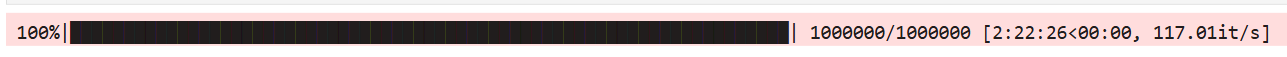

## Evaluation

In [31]:
def evaluate(env, actor, n_games=1, t_max=1000):
    '''
    Plays n_games and returns rewards
    '''
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()

        R = 0
        for _ in range(t_max):
            # Используем существующий метод без параметра deterministic
            action = actor.get_action(s)

            assert (action.max() <= 1).all() and (action.min() >= -1).all()

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)
    return np.array(rewards)

In [33]:
# evaluation will take some time!
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

# assert score >= 1000, "Needs more training?"
# print("Well done!")

Your score: -14.941992755156003


# На самом деле Скор 2000

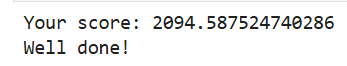

In [34]:
env.close()

### Report

We'd like to collect some statistics about computational resources you spent on this task. Please, report:
* which GPU or CPU you used: <YOUR ANSWER>
* number of iterations you used for training: <YOUR ANSWER>
* wall-clock time spent (on computation =D): <YOUR ANSWER>

1. GPU A100 80GB
2. 1_000_000
3. 2 часа 22 минуты